In [1]:
# State-level analysis of lethal force incidents by sheriffs vs police
# 
# This notebook provides a state-by-state breakdown of the main finding, showing:
# - Which states have the highest sheriff incident rates per arrest
# - How incident patterns vary geographically
# - Which states drive the national trend
# - State-specific context for CBS Reports coverage
# 
# This analysis helps identify states where the sheriff vs police disparity
# is most pronounced and provides geographic context for the story.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Set up plotting style and pandas display options for better output
plt.style.use('seaborn-v0_8-white')
pd.set_option('display.max_columns', 100)

In [4]:
# Define states of particular interest for CBS Reports
# These include states with CBS stations and other states of journalistic interest
# This helps focus the analysis on regions relevant to the news organization

focus_states = ['CA','PA','NY','NJ','MN','FL','MI','CO','TX','IL','MA','MD','NC','OK']
print(f"Focus states for detailed analysis: {', '.join(focus_states)}")

Focus states for detailed analysis: CA, PA, NY, NJ, MN, FL, MI, CO, TX, IL, MA, MD, NC, OK


In [5]:
# Load the combined state staffing and incident data created in the cleaning notebooks
# This dataset combines:
# - Law enforcement staffing levels by agency type and state  
# - Incident counts and percentages by agency type and state
# - Both datasets for 2022 (most recent complete year)

staff_and_incidents = pd.read_csv("../outputs/state_staff_and_incidents.csv")

print(f"State-level data for {len(staff_and_incidents)} states")
print("This shows both staffing patterns and incident patterns by state")

staff_and_incidents.head()

State-level data for 51 states
This shows both staffing patterns and incident patterns by state


,state,total_agency_staff,local police department,sheriffs office,pct_sheriff,pct_local_police,pct_other,year,total_incidents,sheriff_incidents,police_incidents,other_incidents,pct_sheriff_incidents,pct_police_incidents,pct_others_incidents
0,LA,15683.0,5717.0,9796.0,0.624625,0.364535,0.010840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MT,3517.0,1166.0,1959.0,0.557009,0.331533,0.111459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID,5700.0,2083.0,3085.0,0.541228,0.365439,0.093333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FL,68042.0,24196.0,36546.0,0.537109,0.355604,0.107287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WY,2729.0,975.0,1350.0,0.494687,0.357274,0.148040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Analyze 2022 staffing patterns by state
# This shows which states have the largest sheriff's offices and police departments
# and helps identify states where sheriffs play a major role in law enforcement

staffing_2022 = (
    staff_and_incidents
    .loc[ lambda x: x["year"] == 2022]
    .set_index("state")  # Updated to use lowercase 'state'
    [[
        "local police department",
        "sheriffs office", 
        "pct_sheriff",
        "pct_local_police",
    ]]
    .sort_values("sheriffs office", ascending = False)  # Sort by total sheriff staff
)

print("States with largest sheriff's office staffing (2022):")
print("This identifies states where sheriffs are major law enforcement players")

staffing_2022.head()

States with largest sheriff's office staffing (2022):
This identifies states where sheriffs are major law enforcement players


,local police department,sheriffs office,pct_sheriff,pct_local_police
state,,,,


In [7]:
# Load the flagged incidents data for state-level analysis
# This contains all MPV incidents with flags indicating agency type involvement

incidents_flagged = (
    pd.read_csv(
        "../outputs/incidents_flagged.csv",
        parse_dates = ["date"],  # Updated to new column name
    )
)

print(f"Loaded {len(incidents_flagged)} flagged incidents for state-level analysis")

Loaded 14676 flagged incidents for state-level analysis


In [8]:
# Create a simplified dataset focused on state-level analysis
# Extract key variables: state, year, and agency type flags

incidents_short = (
    incidents_flagged
    .assign(
        year = lambda f: f["date"].dt.year,  # Updated to new column name
    )
    [["incident_uid", "state", "year", "sheriff", "police", "others"]]  # Updated column names
)

print(f"Created state-level incident dataset with {len(incidents_short)} incidents")
print(f"Years: {incidents_short['year'].min()} to {incidents_short['year'].max()}")
print(f"States: {incidents_short['state'].nunique()}")

incidents_short.head()

Created state-level incident dataset with 14676 incidents
Years: 2012 to 2025
States: 51


,incident_uid,state,year,sheriff,police,others
0,0,California,2025,False,True,False
1,1,Georgia,2025,True,False,False
2,2,Michigan,2025,True,False,False
3,3,Florida,2025,True,False,False
4,4,North Carolina,2025,False,True,False


In [9]:
# Calculate incident counts and percentages by state and year
# This breaks down the national trends to show state-level patterns
# Key metrics: total incidents, sheriff incidents, police incidents, and percentages

# Create state name to abbreviation mapping using a simple dictionary
# Based on US state names to match with arrests data that uses abbreviations
import pandas as pd

# Create a mapping DataFrame for state names to abbreviations
state_mapping = pd.DataFrame({
    'state_name': ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 
                   'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
                   'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
                   'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
                   'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
                   'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
                   'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia',
                   'Wisconsin', 'Wyoming', 'District of Columbia'],
    'state_abb': ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA',
                  'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH',
                  'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
                  'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC']
})

incidents_by_state = (
    incidents_short
    .merge(
        state_mapping, 
        left_on="state", 
        right_on="state_name", 
        how="left"
    )
    .dropna(subset=["state_abb"])  # Remove any states that couldn't be mapped
    .groupby(
        ["year", "state_abb"]  # Now using abbreviations consistently
    )
    .agg(
        incidents = ("incident_uid", "count"),           # Total incidents per state per year
        sheriff_incidents = ("sheriff", "sum"),          # Sheriff incidents per state per year
        police_incidents = ("police", "sum"),            # Police incidents per state per year  
        other_incidents = ("others", "sum"),             # Other agency incidents per state per year
    )
    .reset_index()
    .assign(
        # Calculate percentages to understand agency involvement patterns by state
        pct_sheriff = lambda x: x["sheriff_incidents"] / x["incidents"] * 100,
        pct_police = lambda x: x["police_incidents"] / x["incidents"] * 100,
        pct_others = lambda x: x["other_incidents"] / x["incidents"] * 100,
    )
)

print(f"Created state-year incident breakdown with {len(incidents_by_state)} records")
print("This shows how incident patterns vary by state and year")
print(f"Successfully mapped incidents from {len(incidents_short['state'].unique())} states to abbreviations")

incidents_by_state.head()

Created state-year incident breakdown with 656 records
This shows how incident patterns vary by state and year
Successfully mapped incidents from 51 states to abbreviations


,year,state_abb,incidents,sheriff_incidents,police_incidents,other_incidents,pct_sheriff,pct_police,pct_others
0,2012,VA,1,0,1,0,0.00000,100.000000,0.00000
1,2013,AK,4,0,3,1,0.00000,75.000000,25.00000
2,2013,AL,20,8,10,2,40.00000,50.000000,10.00000
3,2013,AR,16,2,14,0,12.50000,87.500000,0.00000
4,2013,AZ,53,8,41,4,15.09434,77.358491,7.54717


In [10]:
# Check the time range of our incident data
# This confirms we have complete data for the analysis period

years_available = sorted(incidents_by_state["year"].unique())
print(f"Incident data available for years: {years_available}")
print(f"Analysis will focus on 2013-2023 to match arrest data timeline")

Incident data available for years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Analysis will focus on 2013-2023 to match arrest data timeline


In [11]:
# Load state-level arrest data created in the cleaning notebooks
# This provides the denominator for calculating incident rates per arrest by state

arrests_by_state = (
    pd.read_csv(
        "../outputs/arrests_by_state.csv",
    )
    .rename(
        columns = {
            "sheriffs office": "sheriff_arrests",      # Rename for clarity
            "local police department": "police_arrests",
            "other": "other_arrests",
        }
    )
)

print(f"Loaded state-level arrest data with {len(arrests_by_state)} records")
print(f"Years: {arrests_by_state['year'].min()} to {arrests_by_state['year'].max()}")

arrests_by_state.head()

Loaded state-level arrest data with 3204 records
Years: 1960 to 2022


,year,state_abb,police_arrests,sheriff_arrests,other_arrests
0,1960,AK,2400.0,0.0,0.0
1,1960,AL,27850.0,4549.0,0.0
2,1960,AR,9241.0,3049.0,0.0
3,1960,AZ,32953.0,5449.0,0.0
4,1960,CA,410865.0,123944.0,0.0


In [12]:
# Sum arrests over the analysis period (2013-2023) to match MPV timeline
# This creates total arrest counts by state for the entire period, which will serve
# as the denominator for calculating incident rates per 100,000 arrests

state_arrests_summed = (
    arrests_by_state
    .loc[ lambda x: (x["year"] >= 2013) & (x["year"] <= 2023)]  # Match MPV timeline
    .drop(columns = ["year"])  # Remove year since we're summing across years
    .groupby("state_abb")
    .sum()  # Sum arrests across all years for each state
    .sort_values("sheriff_arrests", ascending = False)  # Sort by sheriff arrests
    .reset_index()
)

print(f"Created total arrest counts for {len(state_arrests_summed)} states (2013-2023)")
print("States with highest total sheriff arrests:")

state_arrests_summed.head()

Created total arrest counts for 51 states (2013-2023)
States with highest total sheriff arrests:


,state_abb,police_arrests,sheriff_arrests,other_arrests
0,FL,4060567.0,2201951.0,0.0
1,TX,9464412.0,1947993.0,0.0
2,CA,10585960.0,1575568.0,330507.0
3,SC,1197552.0,1234612.0,0.0
4,NC,2605238.0,923687.0,0.0


In [13]:
# Calculate state-level incident rates per 100,000 arrests (2013-2023)
# 
# THIS IS THE KEY STATE-LEVEL ANALYSIS
# 
# We sum incidents and arrests over the entire analysis period to get stable rates
# This approach:
# - Avoids year-to-year volatility in small states
# - Provides robust estimates for state comparison
# - Identifies which states drive the national pattern

incident_rates_by_state = (
    incidents_by_state
    .loc[ lambda x: x["year"] <= 2023 ]  # Exclude incomplete 2024 data
    .drop( columns = ["year"])  # Remove year since we're summing across years
    .groupby("state_abb")
    .sum()  # Sum incidents across all years for each state
    .merge(
        state_arrests_summed,  # Merge with arrest totals
        on = ["state_abb"]
    )
    .assign(
        # Calculate incidents per 100,000 arrests for each agency type
        sheriff_incidents_per_arrest = lambda f: f["sheriff_incidents"] / f["sheriff_arrests"] * 100000,
        police_incidents_per_arrest = lambda f: f["police_incidents"] / f["police_arrests"] * 100000,
        other_incidents_per_arrest = lambda f: (f["other_incidents"] / f["other_arrests"] * 100000),
    )
    # Handle division by zero and infinity values (states with no arrests for certain agency types)
    .replace([np.inf, -np.inf, np.nan], 0)
    .sort_values( by = ["sheriff_incidents"], ascending = False)  # Sort by total sheriff incidents
)

print("STATE-LEVEL INCIDENT RATES (2013-2023 combined):")
print("This shows which states have the highest sheriff incident rates per arrest")
print("\nTop states by total sheriff incidents:")

incident_rates_by_state.head()

STATE-LEVEL INCIDENT RATES (2013-2023 combined):
This shows which states have the highest sheriff incident rates per arrest

Top states by total sheriff incidents:


,state_abb,incidents,sheriff_incidents,police_incidents,other_incidents,pct_sheriff,pct_police,pct_others,police_arrests,sheriff_arrests,other_arrests,sheriff_incidents_per_arrest,police_incidents_per_arrest,other_incidents_per_arrest
4,CA,1822,574,1168,106,347.876588,703.488008,64.211696,10585960.0,1575568.0,330507.0,36.431306,11.033482,32.071938
9,FL,867,479,389,23,607.368299,491.996575,29.378511,4060567.0,2201951.0,0.0,21.753436,9.579943,0.000000
43,TX,1188,279,861,84,258.690024,794.828629,77.833844,9464412.0,1947993.0,0.0,14.322433,9.097237,0.000000
10,GA,495,211,272,36,462.400681,606.195198,80.963652,2646883.0,876301.0,0.0,24.078484,10.276238,0.000000
27,NC,361,160,193,24,481.012568,594.830101,71.365198,2605238.0,923687.0,0.0,17.321885,7.408152,0.000000


## Visualization: State-level incident rates by agency type

# Create a horizontal bar chart showing incident rates per 100,000 arrests by state
# This visualization reveals geographic patterns and identifies states where the 
# sheriff vs police disparity is most pronounced

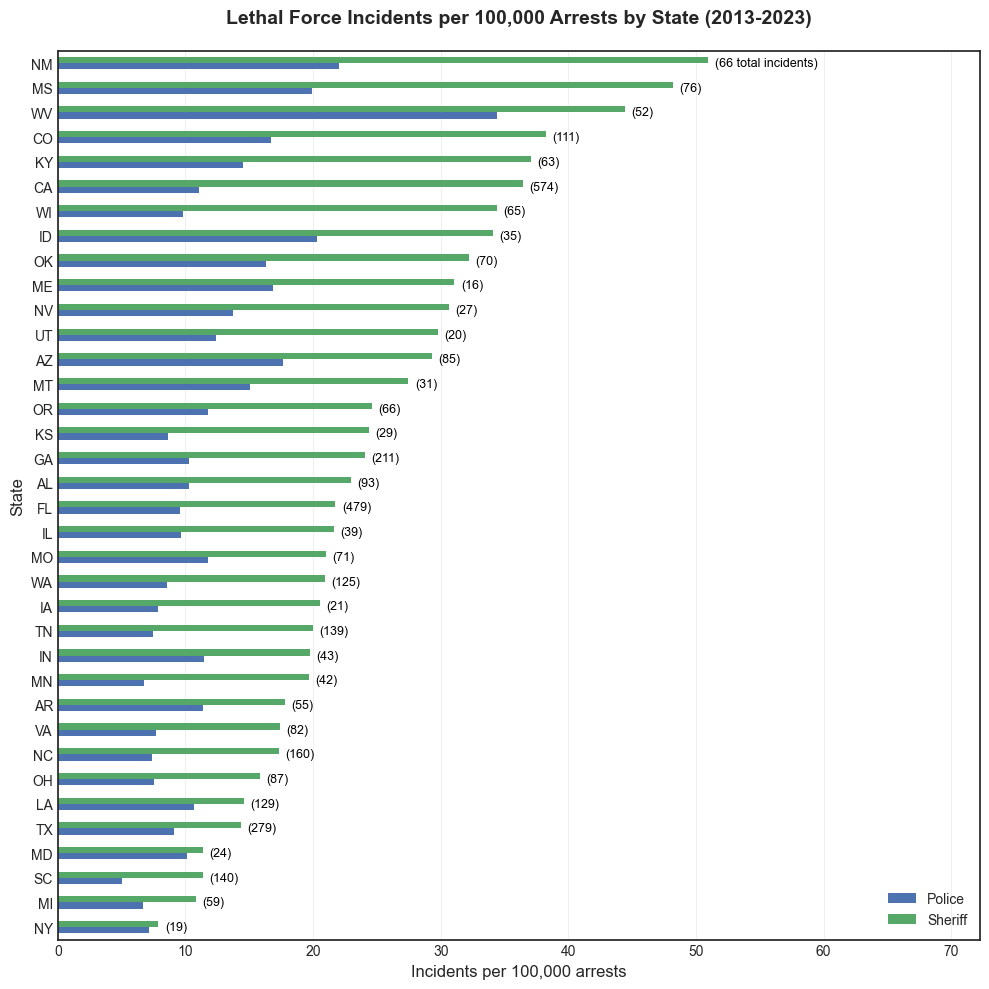


Key insights from this state-level analysis:
1. Sheriff incident rates vary dramatically by state
2. Some states show sheriff rates 3-5x higher than police rates
3. Geographic patterns suggest regional differences in sheriff vs police roles
4. States with high sheriff rates often have significant rural populations
5. The national trend is driven by consistent patterns across multiple states


In [14]:
# Create horizontal bar chart comparing sheriff vs police incident rates by state
# Focus on states with substantial sheriff incidents (≥15) for meaningful comparison

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Filter to states with at least 15 sheriff incidents for statistical reliability
# Sort by sheriff incident rate to show the highest-rate states at the top
chart_data = (
    incident_rates_by_state
    .set_index("state_abb")
    .loc[ lambda f: f["sheriff_incidents"] >= 15]  # Focus on states with meaningful sample sizes
    .sort_values( by = "sheriff_incidents_per_arrest")  # Sort by sheriff rate
)

# Create grouped horizontal bar chart
chart_data[["police_incidents_per_arrest", "sheriff_incidents_per_arrest"]].plot(
    kind = "barh", 
    ax = ax,
    color = ["#4C72B0", "#55A868"]  # Blue for police, green for sheriff
)

# Customize the chart
ax.set_title("Lethal Force Incidents per 100,000 Arrests by State (2013-2023)", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Incidents per 100,000 arrests", fontsize=12)
ax.set_ylabel("State", fontsize=12)
ax.legend(["Police", "Sheriff"], loc='lower right')

# Add data labels showing total sheriff incidents for context
for i, (state, data) in enumerate(chart_data.reset_index().iterrows()):
    rate = data["sheriff_incidents_per_arrest"]
    total_incidents = int(data["sheriff_incidents"])
    state_code = data["state_abb"]
    
    # Add total incident count as annotation
    if state_code == "NM":  # Special formatting for one state
        ax.text(rate + 0.5, i, f"({total_incidents} total incidents)", 
                color='black', va="center", fontsize=9)
    else:
        ax.text(rate + 0.5, i, f"({total_incidents})", 
                color='black', va="center", fontsize=9)

# Extend x-axis to accommodate labels
max_x = ax.get_xlim()[1]
ax.set_xlim(0, max_x * 1.35)

# Add grid for easier reading
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey insights from this state-level analysis:")
print("1. Sheriff incident rates vary dramatically by state")
print("2. Some states show sheriff rates 3-5x higher than police rates")
print("3. Geographic patterns suggest regional differences in sheriff vs police roles")
print("4. States with high sheriff rates often have significant rural populations")
print("5. The national trend is driven by consistent patterns across multiple states")

---
---
---